# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp311-cp311-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3


In [2]:
# Install required packages
from sagemaker.tuner import (
    HyperparameterTuner, CategoricalParameter, ContinuousParameter)
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig, Rule, rule_configs, ProfilerRule, ProfilerConfig, FrameworkProfile
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
import sagemaker
import boto3
!pip install smdebug


sagemaker_session = sagemaker.Session(default_bucket="udacity-project-image-classication")
role = get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

print(role)
print(region)
print(bucket)

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
arn:aws:iam::438465124937:role/service-role/AmazonSageMaker-ExecutionRole-20250405T234080
us-east-2
udacity-project-image-classication


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [3]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://udacity-nn-image-classification.s3.us-east-2.amazonaws.com/dogImages.zip
!unzip dogImages.zip

# Storing in S3
!aws s3 cp dogImages s3://{bucket}/dogImages/ --recursive

--2025-04-06 19:24:13--  https://udacity-nn-image-classification.s3.us-east-2.amazonaws.com/dogImages.zip
Resolving udacity-nn-image-classification.s3.us-east-2.amazonaws.com (udacity-nn-image-classification.s3.us-east-2.amazonaws.com)... 3.5.133.179, 52.219.233.138, 52.219.110.114, ...
Connecting to udacity-nn-image-classification.s3.us-east-2.amazonaws.com (udacity-nn-image-classification.s3.us-east-2.amazonaws.com)|3.5.133.179|:443... connected.
200 OKequest sent, awaiting response... 
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  70.0MB/s    in 14s     

2025-04-06 19:24:27 (78.7 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dog

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [3]:
# Hyperparameter tuning config
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "eps": ContinuousParameter(1e-9, 1e-8),
    "weight_decay": ContinuousParameter(1e-3, 1e-1),
    "batch_size": CategoricalParameter([64, 128])
}

metric_definitions = [
    {'Name': 'average test loss',
        'Regex': 'Test set: Average loss: ([0-9\.]+)'}
]

objective_metric_name = 'average test loss'
objective_type = 'Minimize'

In [4]:
# Estimator for HPO
hpo_estimator = PyTorch(
    entry_point='hpo.py',
    role=role,
    framework_version='1.12.0',
    py_version='py38',
    instance_count=1,
    instance_type='ml.m5.large',
    metric_definitions=metric_definitions,
    base_job_name="pytorch-dog-hpo"
)

# Tuner
tuner = HyperparameterTuner(
    estimator=hpo_estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    objective_type=objective_type,
    max_jobs=8,
    max_parallel_jobs=2
)

In [5]:
# Train your HP Tuner
tuner.fit({"training": f"s3://{bucket}/dogImages/"})
tuner.wait()

[04/08/25 01:58:16] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=388863;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=342748;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    WARNING  No finished training job found associated with this estimator.       ]8;id=259862;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=304071;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  No finished training job found associated with this estimator.       ]8;id=632134;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=554501;file:///opt/conda/lib/python3.11/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=367716;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=376219;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating hyperparameter tuning job with name:                          ]8;id=535116;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=121425;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#3383\3383]8;;\
                             pytorch-training-250408-0158                                                          

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [6]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
print("Best Hyperparameters: ", best_estimator.hyperparameters())

best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'eps': best_estimator.hyperparameters()['eps'],
                      'lr': best_estimator.hyperparameters()['lr'],
                      'weight_decay': best_estimator.hyperparameters()['weight_decay'],}
print(f"Best Hyperparamters post Hyperparameter fine tuning are : \n {best_hyperparameters}")



2025-04-08 06:01:59 Starting - Found matching resource for reuse
2025-04-08 06:01:59 Downloading - Downloading the training image
2025-04-08 06:01:59 Training - Training image download completed. Training in progress.
2025-04-08 06:01:59 Uploading - Uploading generated training model
2025-04-08 06:01:59 Completed - Resource released due to keep alive period expiry
Best Hyperparameters:  {'_tuning_objective_metric': '"average test loss"', 'batch_size': '"128"', 'eps': '9.328574083907704e-09', 'lr': '0.0004436403958812334', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"pytorch-dog-hpo-2025-04-08-01-58-15-790"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-2"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-2-438465124937/pytorch-dog-hpo-2025-04-08-01-58-15-790/source/sourcedir.tar.gz"', 'weight_decay': '0.009824102616494291'}
Best Hyper

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [45]:
#Set up debugging and profiling rules

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.confusion()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10)
)


collection_configs = [
    CollectionConfig(name="biases"),
    CollectionConfig(name="metrics",
                     parameters={"include_regex": ".*accuracy|.*loss",
                                 "train.save_interval": "10",
                                 "eval.save_interval": "1"
    }),
    CollectionConfig(name="CrossEntropyLoss_output_0",
                     parameters={"include_regex": "CrossEntropyLoss_output_0",
                                 "train.save_interval": "10",
                                 "eval.save_interval": "1"})]

debugger_hook_config = DebuggerHookConfig(
    s3_output_path=f's3://{bucket}/debug-output',
    collection_configs=collection_configs)

[04/09/25 01:49:32] WARNING  Framework profiling will be deprecated from tensorflow 2.12 and     ]8;id=374743;file:///opt/conda/lib/python3.11/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=381666;file:///opt/conda/lib/python3.11/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             pytorch 2.0 in sagemaker>=2.                                                          
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

In [ ]:
# Create and fit Estimator

estimator = PyTorch(
    entry_point='train_model.py',
    role=role,
    framework_version='1.12.0',
    py_version='py38',
    instance_count=1,
    instance_type='ml.m5.large',
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_hook_config,
    metric_definitions=metric_definitions,
    rules=rules,
    base_job_name="pytorch-dog-train"
)
estimator.fit({"training": f"s3://{bucket}/dogImages/"}, wait=True)

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=396729;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=695979;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

[04/09/25 01:49:33] INFO     Ignoring unnecessary instance type: None.                            ]8;id=818338;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=942425;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=957519;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=522842;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=286479;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=282137;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=288172;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=577472;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=708577;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=886453;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=918521;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=154356;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=728993;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=2232;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=96415;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=999976;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

[04/09/25 01:49:34] INFO     Creating training-job with name:                                       ]8;id=674780;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=431649;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             pytorch-dog-train-2025-04-09-01-49-32-932                                             

2025-04-09 01:49:34 Starting - Starting the training job...
2025-04-09 01:50:05 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Confusion: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
..
.....04-09 01:50:36 Downloading - Downloading input data.

In [50]:
#Fetching jobname , client and description to be used for plotting.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
print(f"Jobname: {job_name}")
print(f"Client: {client}")
print(f"Description: {description}")

Jobname: pytorch-dog-train-2025-04-09-01-49-32-932
Client: <botocore.client.SageMaker object at 0x7f4157180050>
Description: {'TrainingJobName': 'pytorch-dog-train-2025-04-09-01-49-32-932', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-2:438465124937:training-job/pytorch-dog-train-2025-04-09-01-49-32-932', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-2-438465124937/pytorch-dog-train-2025-04-09-01-49-32-932/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '128', 'eps': '"9.328574083907704e-09"', 'lr': '"0.0004436403958812334"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-dog-train-2025-04-09-01-49-32-932"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-2"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-2-438465124937/pytorch-dog-train-2025-04-09-01-49-32-932/source/sourcedir.tar.gz"', 'weight_decay': '"0.009824102616494291"'}, 'Algorithm

In [51]:
#Defining a Trail

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial.tensor_names()


[2025-04-09 02:53:47.229 default:121 INFO s3_trial.py:42] Loading trial debug-output at path s3://udacity-project-image-classication/debug-output/pytorch-dog-train-2025-04-09-01-49-32-932/debug-output


['CrossEntropyLoss_output_0',
 'ResNet_bn1.bias',
 'ResNet_fc.0.bias',
 'ResNet_fc.2.bias',
 'ResNet_layer1.0.bn1.bias',
 'ResNet_layer1.0.bn2.bias',
 'ResNet_layer1.0.bn3.bias',
 'ResNet_layer1.0.downsample.1.bias',
 'ResNet_layer1.1.bn1.bias',
 'ResNet_layer1.1.bn2.bias',
 'ResNet_layer1.1.bn3.bias',
 'ResNet_layer1.2.bn1.bias',
 'ResNet_layer1.2.bn2.bias',
 'ResNet_layer1.2.bn3.bias',
 'ResNet_layer2.0.bn1.bias',
 'ResNet_layer2.0.bn2.bias',
 'ResNet_layer2.0.bn3.bias',
 'ResNet_layer2.0.downsample.1.bias',
 'ResNet_layer2.1.bn1.bias',
 'ResNet_layer2.1.bn2.bias',
 'ResNet_layer2.1.bn3.bias',
 'ResNet_layer2.2.bn1.bias',
 'ResNet_layer2.2.bn2.bias',
 'ResNet_layer2.2.bn3.bias',
 'ResNet_layer2.3.bn1.bias',
 'ResNet_layer2.3.bn2.bias',
 'ResNet_layer2.3.bn3.bias',
 'ResNet_layer3.0.bn1.bias',
 'ResNet_layer3.0.bn2.bias',
 'ResNet_layer3.0.bn3.bias',
 'ResNet_layer3.0.downsample.1.bias',
 'ResNet_layer3.1.bn1.bias',
 'ResNet_layer3.1.bn2.bias',
 'ResNet_layer3.1.bn3.bias',
 'ResNet_la

loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


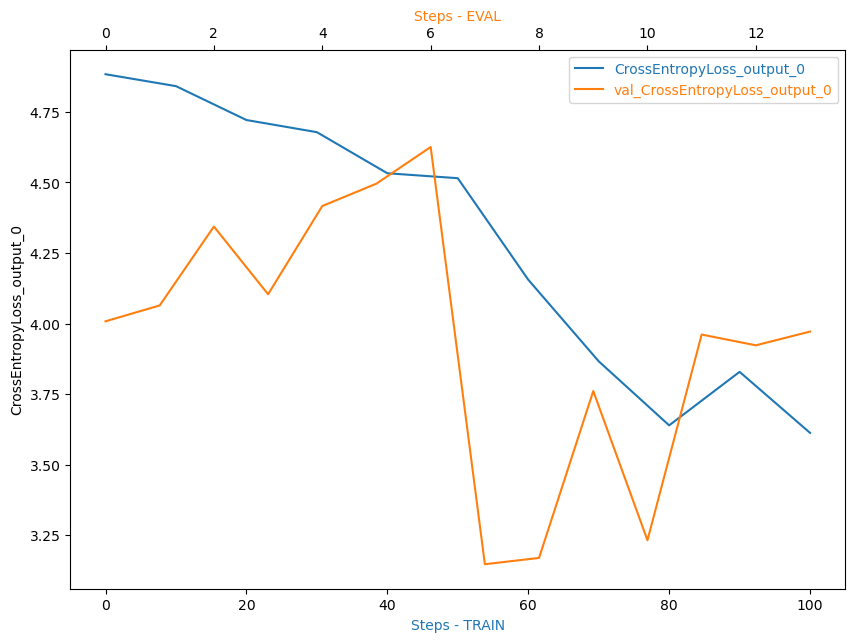

In [52]:
#Plotting a debugging output.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

#Setting a utility function to get data from tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

#Plotting tensor utility functions for plotting tensors
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps - TRAIN")
    par.set_xlabel("Steps - EVAL")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [55]:
# Display the profiler output
rule_output = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"Profiler report path: {rule_output}")
! aws s3 ls {rule_output} --recursive

Profiler report path: s3://sagemaker-us-east-2-438465124937/pytorch-dog-train-2025-04-09-01-49-32-932/rule-output
2025-04-09 02:53:02     363047 pytorch-dog-train-2025-04-09-01-49-32-932/rule-output/ProfilerReport/profiler-output/profiler-report.html
2025-04-09 02:53:02     209087 pytorch-dog-train-2025-04-09-01-49-32-932/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2025-04-09 02:52:57        192 pytorch-dog-train-2025-04-09-01-49-32-932/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2025-04-09 02:52:57        200 pytorch-dog-train-2025-04-09-01-49-32-932/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2025-04-09 02:52:57       1778 pytorch-dog-train-2025-04-09-01-49-32-932/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2025-04-09 02:52:57        127 pytorch-dog-train-2025-04-09-01-49-32-932/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2025-0

In [70]:
! aws s3 cp {rule_output} ./ --recursive

download: s3://sagemaker-us-east-2-438465124937/pytorch-dog-train-2025-04-09-01-49-32-932/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-2-438465124937/pytorch-dog-train-2025-04-09-01-49-32-932/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-2-438465124937/pytorch-dog-train-2025-04-09-01-49-32-932/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-2-438465124937/pytorch-dog-train-2025-04-09-01-49-32-932/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-2-438465124937/py

In [71]:
import os
from IPython.display import HTML

# Get the autogenerated folder name of the profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

# Display the profiler report
HTML(filename=os.path.join(profiler_report_name, "profiler-output", "profiler-report.html"))


In [72]:
# Zipping the ProfilerReport inorder to export and upload it later for submission
import shutil
shutil.make_archive("./profiler_report", "zip", "ProfilerReport")

'/home/sagemaker-user/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/profiler_report.zip'

## Model Deploying

In [73]:
# Deploy your model to an endpoint

predictor=estimator.deploy(initial_instance_count=1,
                          instance_type="ml.m5.xlarge")

[04/09/25 04:24:22] INFO     Repacking model artifact                                                  ]8;id=367572;file:///opt/conda/lib/python3.11/site-packages/sagemaker/model.py\model.py]8;;\:]8;id=454084;file:///opt/conda/lib/python3.11/site-packages/sagemaker/model.py#819\819]8;;\
                             (s3://sagemaker-us-east-2-438465124937/pytorch-dog-train-2025-04-09-01-49             
                             -32-932/output/model.tar.gz), script artifact                                         
                             (s3://sagemaker-us-east-2-438465124937/pytorch-dog-train-2025-04-09-01-49             
                             -32-932/source/sourcedir.tar.gz), and dependencies ([]) into single                   
                             tar.gz file located at                                                                
                             s3://sagemaker-us-east-2-438465124937/pytorch-dog-train-2025-04-09-04-24-             
                             21-911/model.tar.gz. This may take some time depending on model size...               

[04/09/25 04:24:30] INFO     Creating model with name: pytorch-dog-train-2025-04-09-04-24-21-911    ]8;id=431796;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=679971;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating endpoint-config with name                                     ]8;id=555804;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=383816;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#5889\5889]8;;\
                             pytorch-dog-train-2025-04-09-04-24-21-911                                             

[04/09/25 04:24:31] INFO     Creating endpoint with name pytorch-dog-train-2025-04-09-04-24-21-911  ]8;id=782220;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=547027;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4711\4711]8;;\

------!

In [77]:
import sagemaker
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

sess  = sagemaker.Session()
role  = sagemaker.get_execution_role()

model_data_artifacts = ("s3://sagemaker-us-east-2-438465124937/pytorch-training-250408-0158-008-22591d02/output/model.tar.gz")

jpeg_serializer  = IdentitySerializer(content_type="image/jpeg")
json_deserializer = JSONDeserializer()

class ImgPredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session=sess):
        super().__init__(
            endpoint_name=endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

pytorch_model = PyTorchModel(model_data=model_data_artifacts,
                             role=role,
                             entry_point="inference_endpoint.py",
                             framework_version="2.3",
                             py_version="py311",
                             predictor_cls=ImgPredictor)

predictor = pytorch_model.deploy(initial_instance_count=1,
                                 instance_type="ml.m5.large")


[04/09/25 04:55:12] INFO     Repacking model artifact                                                  ]8;id=63055;file:///opt/conda/lib/python3.11/site-packages/sagemaker/model.py\model.py]8;;\:]8;id=177127;file:///opt/conda/lib/python3.11/site-packages/sagemaker/model.py#819\819]8;;\
                             (s3://sagemaker-us-east-2-438465124937/pytorch-training-250408-0158-008-2             
                             2591d02/output/model.tar.gz), script artifact (None), and dependencies                
                             ([]) into single tar.gz file located at                                               
                             s3://sagemaker-us-east-2-438465124937/pytorch-inference-2025-04-09-04-55-             
                             12-630/model.tar.gz. This may take some time depending on model size...               

[04/09/25 04:55:20] INFO     Creating model with name: pytorch-inference-2025-04-09-04-55-20-336    ]8;id=579922;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=85288;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4094\4094]8;;\

[04/09/25 04:55:21] INFO     Creating endpoint-config with name                                     ]8;id=525957;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=873005;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#5889\5889]8;;\
                             pytorch-inference-2025-04-09-04-55-21-291                                             

                    INFO     Creating endpoint with name pytorch-inference-2025-04-09-04-55-21-291  ]8;id=645293;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=877763;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4711\4711]8;;\

------!

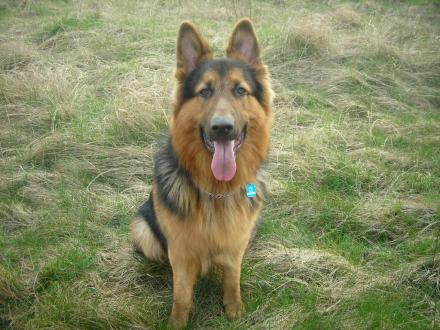

1. TestImg_German_shepherd_dog.jpg → predicted  71 (expected  71)


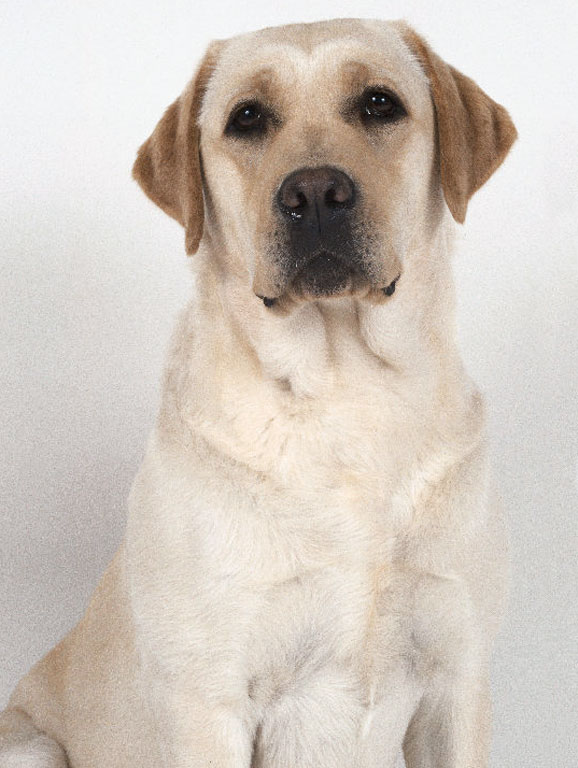

2. TestImg_Labrador_retriever.jpg → predicted  10 (expected  96)


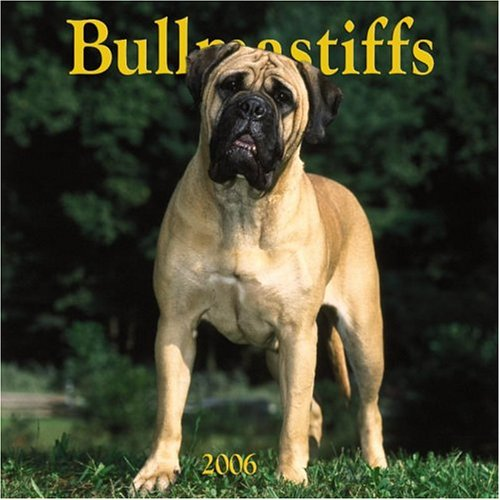

3. TestImg_Bullmastiff.jpg        → predicted  41 (expected  41)

Overall accuracy on 3 samples: 66.7%


In [82]:
from __future__ import annotations
import io
from pathlib import Path
from typing import List

import numpy as np
from PIL import Image
from IPython.display import display   # only needed in notebooks

# CONFIG ------------------------------------------------------------------
TEST_DIR = Path("./testImages")
TEST_IMAGES = [
    ("TestImg_German_shepherd_dog.jpg", 71),
    ("TestImg_Labrador_retriever.jpg",   96),
    ("TestImg_Bullmastiff.jpg",          41),
]
CONTENT_TYPE = "image/jpeg"
SHOW_IMAGES  = True

# DATA LOADING ------------------------------------------------------------
def load_bytes(p: Path) -> bytes:
    with p.open("rb") as f:
        return f.read()

payloads: List[bytes] = [load_bytes(TEST_DIR/f) for f, _ in TEST_IMAGES]
expected = np.asarray([lbl for _, lbl in TEST_IMAGES])

# INFERENCE (one call per image) -----------------------------------------
predictions = [
    predictor.predict(img_bytes, initial_args={"ContentType": CONTENT_TYPE})
    for img_bytes in payloads
]

# POST‑PROCESS ------------------------------------------------------------
predicted = np.argmax(np.vstack(predictions), 1) + 1
acc = (predicted == expected).mean() * 100

for i, (fname, _) in enumerate(TEST_IMAGES):
    if SHOW_IMAGES:
        display(Image.open(io.BytesIO(payloads[i])))
    print(f"{i+1}. {fname:<30} → predicted {predicted[i]:3d} "
          f"(expected {expected[i]:3d})")

print(f"\nOverall accuracy on {len(TEST_IMAGES)} samples: {acc:.1f}%")


In [83]:
# Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

[04/09/25 06:41:48] INFO     Deleting endpoint configuration with name:                             ]8;id=204090;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=390660;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4865\4865]8;;\
                             pytorch-inference-2025-04-09-04-55-21-291                                             

                    INFO     Deleting endpoint with name: pytorch-inference-2025-04-09-04-55-21-291 ]8;id=474516;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=576099;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4855\4855]8;;\